# ======================================
# 📦 1. Chargement des bibliothèques
# ======================================




In [19]:
import pandas as pd
import numpy as np

# ======================================
# 📥 2. Chargement des données
# ======================================





In [20]:
# Chargement des données
df = pd.read_csv("C:/Users/Hermann/Documents/MES_TRAVAUX\DETECTION DE LA FRAUDE/detection_fraude_bancaire _sfdffd/data/sfdffd.csv")  # remplace par ton vrai nom de fichier



# ======================================
# 🧱 3. Création de nouvelles variables
# ======================================

In [21]:
# 0. Ratios entre le montant de la transaction et les soldes d'origine/destination
df['ratioAmountOrig'] = df['amount'] / (df['oldbalanceOrg'] + 1)
df['ratioAmountDest'] = df['amount'] / (df['oldbalanceDest'] + 1)

# 1. Différences de soldes (expéditeur / destinataire) 
df['diff_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['diff_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

# 2. Transactions sans impact sur le solde de l’expéditeur malgré un montant > 0
df['no_balance_change_sender'] = ((df['oldbalanceOrg'] == df['newbalanceOrig']) & (df['amount'] > 0)).astype(int)

# 3. Transactions sans impact sur le solde du destinataire
df['no_balance_change_receiver'] = ((df['oldbalanceDest'] == df['newbalanceDest']) & (df['amount'] > 0)).astype(int)

# 4. Heure estimée de la transaction (step en heures)
df['hour'] = df['step'] % 24

# 5. Indication de gros montant
df['isHighAmount'] = (df['amount'] > 1000000).astype(int)  # Seuil à ajuster selon la distribution

# 6. Le destinataire est-il un marchand ? (nom commence par "M")
df['isMerchantDest'] = df['nameDest'].str.startswith("M").astype(int)

# 7. Le type de transaction est-il à haut risque ?
df['isRiskyType'] = df['type'].isin(['TRANSFER', 'CASH_OUT']).astype(int)


# ======================================
# 👁️ 4. Aperçu des nouvelles variables
# ======================================

In [22]:

df[['amount','ratioAmountOrig', 'ratioAmountDest','diff_orig', 'diff_dest', 'no_balance_change_sender',
    'no_balance_change_receiver', 'hour', 'isHighAmount',
    'isMerchantDest', 'isRiskyType']].head()

,amount,ratioAmountOrig,ratioAmountDest,diff_orig,diff_dest,no_balance_change_sender,no_balance_change_receiver,hour,isHighAmount,isMerchantDest,isRiskyType
0,9839.64,0.057834,9839.640000,9839.64,0.0,0,1,1,0,1,0
1,1864.28,0.087731,1864.280000,1864.28,0.0,0,1,1,0,1,0
2,181.00,0.994505,181.000000,181.00,0.0,0,1,1,0,0,1
3,181.00,0.994505,0.008545,181.00,-21182.0,0,0,1,0,0,1
4,11668.14,0.280788,11668.140000,11668.14,0.0,0,1,1,0,1,0



# ======================================
# 👁️ 5. Analyse des relations entre les nouvellse variables
# ======================================

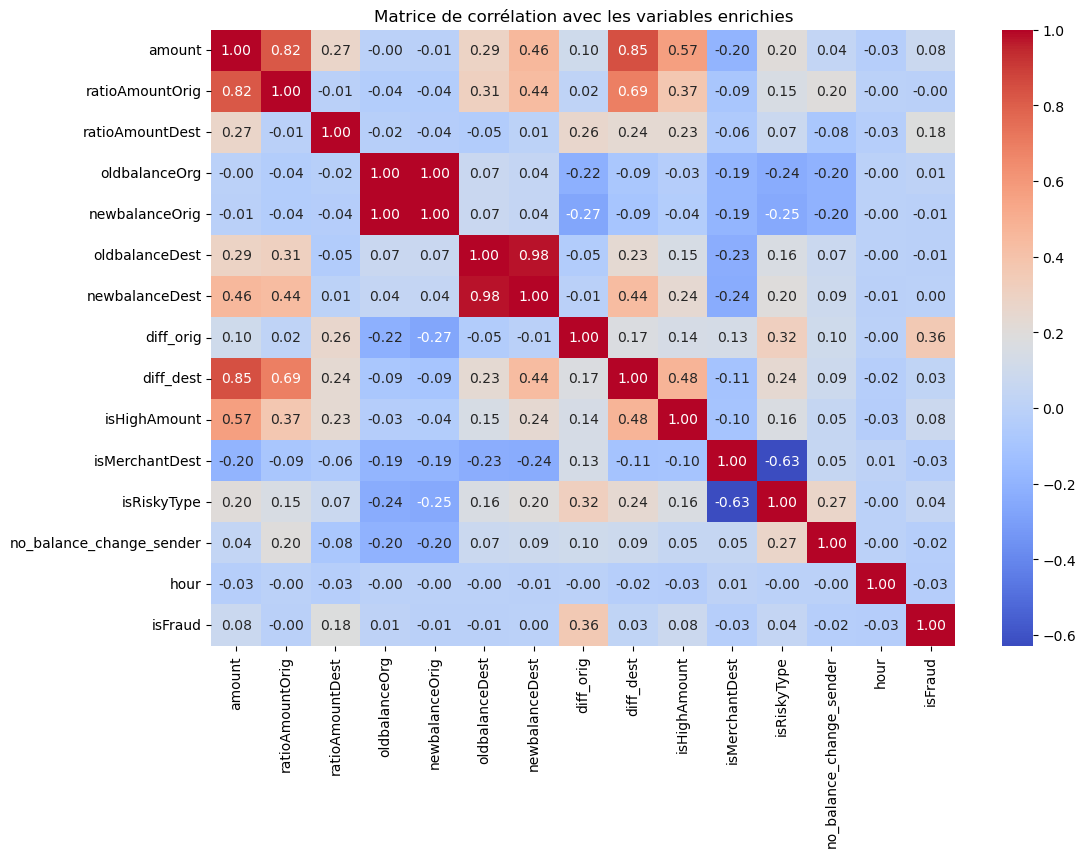

In [23]:
# Sélection des colonnes pertinentes
corr_cols = ['amount','ratioAmountOrig', 'ratioAmountDest', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 
             'newbalanceDest', 'diff_orig', 'diff_dest', 
             'isHighAmount', 'isMerchantDest', 'isRiskyType', 
             'no_balance_change_sender', 'hour', 'isFraud']

# Calcul et affichage de la matrice de corrélation
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation avec les variables enrichies")
plt.show()


# ======================================
# 👁️ 6. selection automatique des  variables
# ======================================

In [26]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler

# Variables explicatives (met ici tes colonnes finales)
features = ['amount','ratioAmountOrig', 'ratioAmountDest', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 
             'newbalanceDest', 'diff_orig', 'diff_dest', 
             'isHighAmount', 'isMerchantDest', 'isRiskyType', 
             'no_balance_change_sender', 'hour']

X = df[features]
y = df['isFraud']

# Standardiser les données (obligatoire pour l'analyse de variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [27]:
# Sélection des K meilleures variables
k = 8  # Tu peux ajuster selon ton cas
selector = SelectKBest(score_func=f_classif, k=k)
X_new = selector.fit_transform(X_scaled, y)

# Affichage des variables retenues
selected_features = [features[i] for i in selector.get_support(indices=True)]
print("Variables sélectionnées :", selected_features)

Variables sélectionnées : ['amount', 'ratioAmountDest', 'diff_orig', 'diff_dest', 'isHighAmount', 'isMerchantDest', 'isRiskyType', 'hour']


# ======================================
# 👁️ 7. Equilibrage de la varible cible
# ======================================

In [28]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Sélection des variables finales (issues de l'ingénierie ou sélection automatique)
X = df[selected_features]  # Remplace par ta vraie liste de colonnes sélectionnées
y = df['isFraud']

# Séparation avant rééchantillonnage pour éviter le data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Répartition après SMOTE :")
print(y_train_res.value_counts())


Répartition après SMOTE :
isFraud
0    4448085
1    4448085
Name: count, dtype: int64


 # ======================================
  # 👁️ 8. Preparation finale des donnees
# ======================================

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


# ======================================
# 👁️ 9. modelisation 
# ======================================

## 9.1- Regression Logistique

###  Etape 1: Entrainement du model

In [30]:
from sklearn.linear_model import LogisticRegression

# Création et entraînement
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_scaled, y_train_res)


LogisticRegression(max_iter=1000, random_state=42)

### Etape 2 : Prediction et evaluation

🔹 Test Matrice de confusion
[[1812634   93688]
 [    141    2323]]

🔹 Rapport de classification
              precision    recall  f1-score   support

           0      1.000     0.951     0.975   1906322
           1      0.024     0.943     0.047      2464

    accuracy                          0.951   1908786
   macro avg      0.512     0.947     0.511   1908786
weighted avg      0.999     0.951     0.974   1908786


🔹 ROC AUC : 0.9903


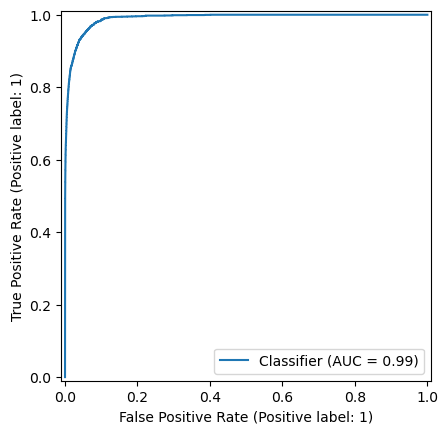

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Prédictions
y_pred_log = log_model.predict(X_test_scaled)
y_proba_log = log_model.predict_proba(X_test_scaled)[:, 1]  # Probabilité d’être fraude (classe 1)

# Matrice de confusion
print("🔹 Test Matrice de confusion")
print(confusion_matrix(y_test, y_pred_log))

# Rapport de classification
print("\n🔹 Rapport de classification")
print(classification_report(y_test, y_pred_log, digits=3))

# Score ROC AUC
roc_score = roc_auc_score(y_test, y_proba_log)
print(f"\n🔹 ROC AUC : {roc_score:.4f}")

# Courbe ROC
RocCurveDisplay.from_predictions(y_test, y_proba_log)


In [32]:
# Prédictions sur le train
y_train_pred = log_model.predict(X_train_scaled)
y_train_proba = log_model.predict_proba(X_train_scaled)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Matrice de confusion
print("🟦 Train : Matrice de confusion")
print(confusion_matrix(y_train_res, y_train_pred))

# Rapport de classification
print("\n🟦 Train : Rapport de classification")
print(classification_report(y_train_res, y_train_pred, digits=3))

# Score ROC AUC
roc_train = roc_auc_score(y_train_res, y_train_proba)
print(f"\n🟦 Train : ROC AUC : {roc_train:.4f}")


🟦 Train : Matrice de confusion
[[4230307  217778]
 [ 141813 4306272]]

🟦 Train : Rapport de classification
              precision    recall  f1-score   support

           0      0.968     0.951     0.959   4448085
           1      0.952     0.968     0.960   4448085

    accuracy                          0.960   8896170
   macro avg      0.960     0.960     0.960   8896170
weighted avg      0.960     0.960     0.960   8896170


🟦 Train : ROC AUC : 0.9928


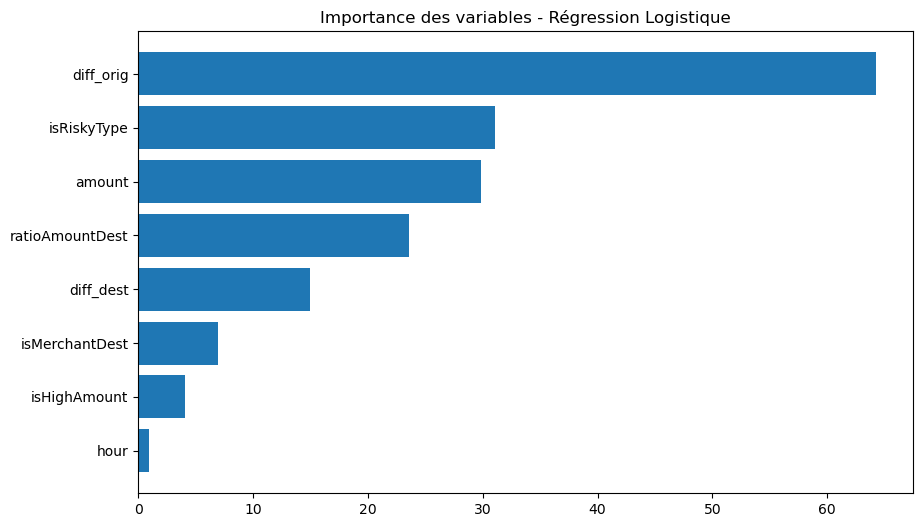

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Importance des variables via les coefficients
coefficients = log_model.coef_[0]  # pour une classification binaire
feature_names = df[selected_features].columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coefficients)  # on prend la valeur absolue des coefficients
}).sort_values(by='Importance', ascending=False)

# Affichage
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Importance des variables - Régression Logistique')
plt.gca().invert_yaxis()
plt.show()


In [50]:
print(len(feature_names))
print(len(coefficients))


14
8


## 9.2- Foret Aleatoire

### Etape 1 :Importation et entrainenment du model

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None, 
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # optionnel si tu n'as pas équilibré manuellement
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

###  Etape 2 : Prediction 

In [36]:
# Sur l'ensemble test
y_pred_test_rf = rf_model.predict(X_test)

# Sur l'ensemble train (pour comparaison)
y_pred_train_rf = rf_model.predict(X_train)


### Etape 3 :Evaluation des performances

#### Ensemble d'entrainement

In [37]:
print("🟦 Train : Matrice de confusion")
print(confusion_matrix(y_train, y_pred_train_rf))
print("\n🟦 Train : Rapport de classification")
print(classification_report(y_train, y_pred_train_rf))
print("🟦 Train : ROC AUC :", roc_auc_score(y_train, rf_model.predict_proba(X_train)[:, 1]))


🟦 Train : Matrice de confusion
[[4448083       2]
 [      1    5748]]

🟦 Train : Rapport de classification
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4448085
           1       1.00      1.00      1.00      5749

    accuracy                           1.00   4453834
   macro avg       1.00      1.00      1.00   4453834
weighted avg       1.00      1.00      1.00   4453834

🟦 Train : ROC AUC : 0.9999999797826069


#### Ensemble de test 

In [38]:
print("🔹 Test : Matrice de confusion")
print(confusion_matrix(y_test, y_pred_test_rf))
print("\n🔹 Test : Rapport de classification")
print(classification_report(y_test, y_pred_test_rf))
print("🔹 Test : ROC AUC :", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))


🔹 Test : Matrice de confusion
[[1906168     154]
 [    731    1733]]

🔹 Test : Rapport de classification
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.92      0.70      0.80      2464

    accuracy                           1.00   1908786
   macro avg       0.96      0.85      0.90   1908786
weighted avg       1.00      1.00      1.00   1908786

🔹 Test : ROC AUC : 0.9383032511170588


## Etape 4: Importance des variables

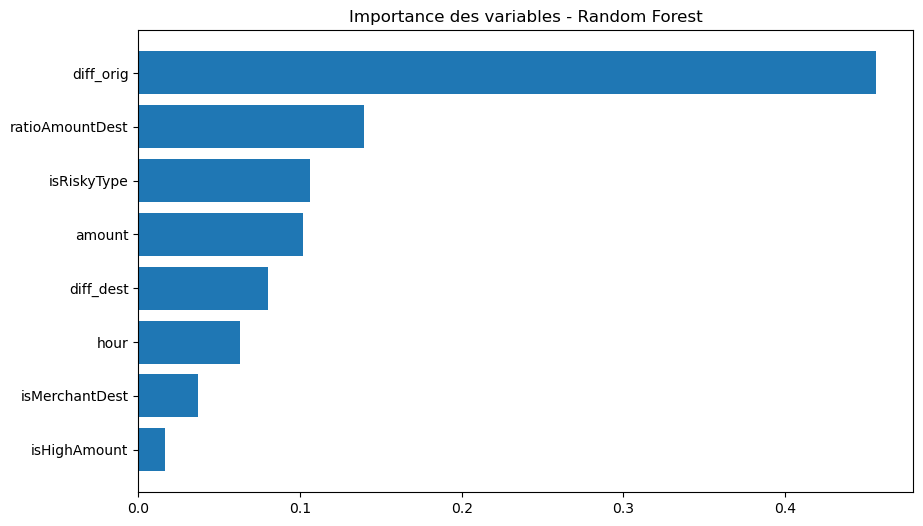

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Importance des variables
importances = rf_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Affichage
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Importance des variables - Random Forest')
plt.gca().invert_yaxis()
plt.show()


## 9.3- Separateur vaste marge (SVM)

### Creation d'un sous echantillon équilibré

In [44]:
data = df[['amount', 'ratioAmountOrig', 'ratioAmountDest', 'oldbalanceOrg', 'newbalanceOrig',
           'oldbalanceDest', 'newbalanceDest', 'diff_orig', 'diff_dest',
           'isHighAmount', 'isMerchantDest', 'isRiskyType',
           'no_balance_change_sender', 'hour', 'isFraud']]


In [45]:
from sklearn.utils import resample

# Séparer les deux classes
fraud = data[data['isFraud'] == 1]
non_fraud = data[data['isFraud'] == 0].sample(n=len(fraud)*5, random_state=42)  # Ratio 1:5

# Fusionner et mélanger
sample_df = pd.concat([fraud, non_fraud])
sample_df = sample_df.sample(frac=1, random_state=42)  # Shuffle

# Séparation X / y
X_sample = sample_df.drop('isFraud', axis=1)
y_sample = sample_df['isFraud']


### pretraitement et entrainement du svm lineaire 

In [48]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Étape 1 : Séparation train / test
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.3, random_state=42
)

# Étape 2 : Pipeline avec SVC linéaire + probabilités
svm_model = make_pipeline(
    StandardScaler(),
    SVC(kernel='linear', probability=True, random_state=42)
)

# Étape 3 : Entraînement
svm_model.fit(X_train, y_train)

### 🔹 Évaluation sur TRAIN
y_train_pred = svm_model.predict(X_train)
y_train_proba = svm_model.predict_proba(X_train)[:, 1]

print("🟦 TRAIN")
print("Matrice de confusion :")
print(confusion_matrix(y_train, y_train_pred))

print("\nRapport de classification :")
print(classification_report(y_train, y_train_pred))

print(f"ROC AUC : {roc_auc_score(y_train, y_train_proba):.4f}")

### 🔹 Évaluation sur TEST
y_test_pred = svm_model.predict(X_test)
y_test_proba = svm_model.predict_proba(X_test)[:, 1]

print("\n🔹 TEST")
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_test_pred))

print("\nRapport de classification :")
print(classification_report(y_test, y_test_pred))

print(f"ROC AUC : {roc_auc_score(y_test, y_test_proba):.4f}")


🟦 TRAIN
Matrice de confusion :
[[28482   342]
 [  828  4842]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28824
           1       0.93      0.85      0.89      5670

    accuracy                           0.97     34494
   macro avg       0.95      0.92      0.94     34494
weighted avg       0.97      0.97      0.97     34494

ROC AUC : 0.9910

🔹 TEST
Matrice de confusion :
[[12114   127]
 [  382  2161]]

Rapport de classification :
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     12241
           1       0.94      0.85      0.89      2543

    accuracy                           0.97     14784
   macro avg       0.96      0.92      0.94     14784
weighted avg       0.97      0.97      0.96     14784

ROC AUC : 0.9909


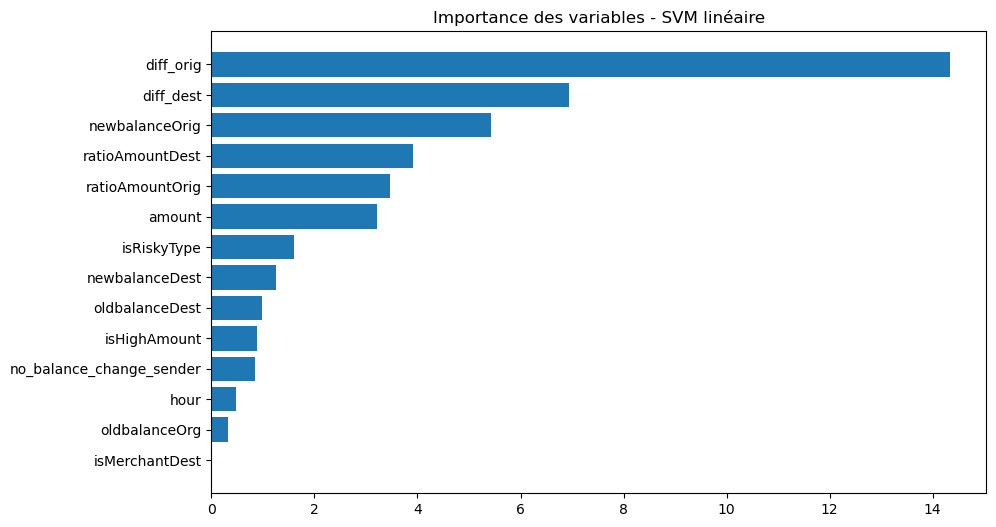

In [57]:
# Extraire le modèle SVM du pipeline
svm_model = svm_model.named_steps['svc']

# Récupérer les coefficients du SVM
coefficients = svm_model.coef_[0]

# Récupération des noms des variables d'origine (avant scaling)
feature_names = X_train.columns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coefficients)
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title("Importance des variables - SVM linéaire")
plt.gca().invert_yaxis()
plt.show()



In [54]:
print(svm_model.steps)


[('standardscaler', StandardScaler()), ('svc', SVC(kernel='linear', probability=True, random_state=42))]
